# Clustering
Use geospatial data as input to clustering algorithm.

Current choice: scikit-learn's `kmeans`

Current inputs: selected GeoTIFFs

#### Functions
- Preprocessing: `sklearn.preprocessing()`
    - Data scaling: `MinMaxScaler`, `StandardScaler`
- Clustering workflow:
    - `from sklearn.cluster import KMeans`
    - `kmeans =  KMeans(n_clusters = 8)` : instantiate object
    - `kmeans.fit(X)` : fit data
    - `kmeans.labels_` : contains cluster labels
    - (optional) `kmeans.predict(new_X)`
- Initialization: `KMeans(init='k-means++')` (default?)
- Elbow method: `kmeans.inertia_` (Within Cluster Sum of Squares - lower is better)
- Silhouette score: distance between clusters

Source(s):
- https://stackabuse.com/k-means-clustering-with-scikit-learn/
- https://stackoverflow.com/questions/48901491/k-means-clustering-on-data-set-with-mixed-data-using-scikit-learn

#### Dealing with categorical data
- "one-hot" representation: separate categorical data with _n_ categories into _n_ new variables with `0` and `1` encoding. This keeps the relative distances correct (e.g., category `1` is not "16" away from category `17`, nor is category `16` closer to `17` than `1` is)
    - See: `pandas.get_dummies`
- Use `k-modes` instead of `k-means` (unclear if this works for mixed categorical and numerical data)

Source(s):
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

#### Normalization/standardization
- Not necessarily required, but ...
- K-means assumes clusters within data are more or less spherical, so ...
- If certain inputs have very high variance, that may affect the shape of clusters within the data.
- A pair-wise plot may be needed to roughly check what we're dealing with (see: `seaborn`)

Source(s):
- https://stats.stackexchange.com/questions/21222/are-mean-normalization-and-feature-scaling-needed-for-k-means-clustering
- https://stats.stackexchange.com/questions/104520/inputs-to-k-means-are-often-normalized-per-feature-why-not-fully-whiten-the-dat
- https://stackoverflow.com/questions/20027645/does-kmeans-normalize-features-automatically-in-sklearn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, osr
import pandas as pd
from pathlib import Path
import rasterio
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [2]:
gdal.UseExceptions()

#### Load data
Preliminary selection:
- Climate indices
- Monthly LAI
- Vegetation height
- Land class (categorical; two data products [MODIS, GLCLU2019])
- Agriculture type (categorical)
- Elevation, slope, aspect
- Sand, silt, clay % (initially just top 15cm layers)
- Fraction organic (initially just top 15cm layers)
- Soil and sediment depth

In [3]:
#base_path = Path('/Users/wmk934/data/perceptual_models/data/geotiff_same_resolution/res_0.0008333333333333334/')
base_path = Path('/Users/wmk934/data/perceptual_models/data/geotiff_same_resolution/res_0.01/')
file_paths = [['climate_fs', base_path / 'worldclim/wc2.1_30s_climate_index_fs_resampled.tif'],
              ['climate_im', base_path / 'worldclim/wc2.1_30s_climate_index_im_resampled.tif'],
              ['climate_imr', base_path / 'worldclim/wc2.1_30s_climate_index_imr_resampled.tif'],
              ['lai_01', base_path / 'lai/2013_2023_01_MOD_Grid_MOD15A2H_Lai_500m_resampled.tif'],
              #['lai_02', base_path / 'lai/2013_2023_02_MOD_Grid_MOD15A2H_Lai_500m_resampled.tif'],
              #['lai_03', base_path / 'lai/2013_2023_03_MOD_Grid_MOD15A2H_Lai_500m_resampled.tif'],
              #['lai_04', base_path / 'lai/2013_2023_04_MOD_Grid_MOD15A2H_Lai_500m_resampled.tif'],
              #['lai_05', base_path / 'lai/2013_2023_05_MOD_Grid_MOD15A2H_Lai_500m_resampled.tif'],
              #['lai_06', base_path / 'lai/2013_2023_06_MOD_Grid_MOD15A2H_Lai_500m_resampled.tif'],
              ['lai_07', base_path / 'lai/2013_2023_07_MOD_Grid_MOD15A2H_Lai_500m_resampled.tif'],
              #['lai_08', base_path / 'lai/2013_2023_08_MOD_Grid_MOD15A2H_Lai_500m_resampled.tif'],
              #['lai_09', base_path / 'lai/2013_2023_09_MOD_Grid_MOD15A2H_Lai_500m_resampled.tif'],
              #['lai_10', base_path / 'lai/2013_2023_10_MOD_Grid_MOD15A2H_Lai_500m_resampled.tif'],
              #['lai_11', base_path / 'lai/2013_2023_11_MOD_Grid_MOD15A2H_Lai_500m_resampled.tif'],
              #['lai_012', base_path / 'lai/2013_2023_12_MOD_Grid_MOD15A2H_Lai_500m_resampled.tif'],
              ['veg_height', base_path / 'forest_height/forest_height_2020_resampled.tif'],
              ['land_class1', base_path / 'glclu2019/glclu2019_map_resampled.tif'],
              ['land_class2', base_path / 'modis_land/2013_2022_mode_MCD12Q1_LC_Type1_resampled.tif'],
              ['agriculture', base_path / 'lgrip30/lgrip30_agriculture_resampled.tif'],
              ['aspect', base_path / 'merit/merit_hydro_aspect_resampled.tif'],
              ['slope', base_path / 'merit/merit_hydro_slope_resampled.tif'],
              ['elev', base_path / 'merit/merit_hydro_elv_resampled.tif'],
              ['clay1', base_path / 'soilgrids/clay_0-5cm_mean_resampled.tif'],
              #['clay2', base_path / 'soilgrids/clay_5-15cm_mean_resampled.tif'],
              ['sand1', base_path / 'soilgrids/sand_0-5cm_mean_resampled.tif'],
              #['sand2', base_path / 'soilgrids/sand_5-15cm_mean_resampled.tif'],
              ['silt1', base_path / 'soilgrids/silt_0-5cm_mean_resampled.tif'],
              #['silt2', base_path / 'soilgrids/silt_5-15cm_mean_resampled.tif'],
              #['soc1', base_path / 'soilgrids/soc_0-5cm_mean_resampled.tif'],
              #['soc2', base_path / 'soilgrids/soc_5-15cm_mean_resampled.tif'],
              ['soil_depth', base_path / 'pelletier/average_soil_and_sedimentary-deposit_thickness_resampled.tif']
]

##### Check that all dimensions match

In [8]:
pixel_sizes = []
raster_sizes = []
bounding_boxes = []

for sub_list in file_paths:
    file = sub_list[1]
    pixel, raster, bb = get_geotiff_properties(file)
    pixel_sizes.append(pixel)
    raster_sizes.append(raster)
    bounding_boxes.append(bb)

In [9]:
assert all([sub_list == pixel_sizes[0] for sub_list in pixel_sizes]), 'pixel sizes don''t match'
assert all([sub_list == raster_sizes[0] for sub_list in raster_sizes]), 'raster sizes don''t match'
assert all([sub_list == bounding_boxes[0] for sub_list in bounding_boxes]), 'bounding boxes don''t match'

Load the data as rasters

In [49]:
# Create a data mask so that we can use a single one for each data product
# We'll arbitrarily use the DEM for this
mask_file1 = str(base_path / 'merit/merit_hydro_elv_resampled.tif')
mask_file2 = str(base_path / 'glclu2019/glclu2019_map_resampled.tif')
mask_main1 = np.ma.masked_equal(get_geotif_data_as_array(mask_file1), get_geotif_noData(mask_file1))
mask_main2 = np.ma.masked_equal(get_geotif_data_as_array(mask_file2), get_geotif_noData(mask_file2))

In [50]:
mask_main_vector1 = mask_main1.mask.reshape(-1,1).squeeze()
mask_main_vector2 = mask_main2.mask.reshape(-1,1).squeeze()

In [54]:
mask_main_vector = mask_main_vector1 | mask_main_vector2

In [72]:
mask_main = mask_main_vector.reshape(np.shape(mask_main1))

In [56]:
data_list = []
columns = []
for ix,sub_list in enumerate(file_paths):
    # progress
    print(f'{ix:02}. Processing {file}')
    column, file = sub_list
    
    # get data we need, skipping tiles masked in the previous step
    str_file = str(file) # convert from Path() to str
    all_data = get_geotif_data_as_array(str_file)
    all_data_vector = all_data.reshape(-1,1).squeeze()
    masked_data = all_data_vector[~mask_main_vector]
    
    # retain data
    data_list.append(masked_data)
    columns.append(column)

00. Processing /Users/wmk934/data/perceptual_models/data/geotiff_same_resolution/res_0.01/pelletier/average_soil_and_sedimentary-deposit_thickness_resampled.tif
01. Processing /Users/wmk934/data/perceptual_models/data/geotiff_same_resolution/res_0.01/worldclim/wc2.1_30s_climate_index_fs_resampled.tif
02. Processing /Users/wmk934/data/perceptual_models/data/geotiff_same_resolution/res_0.01/worldclim/wc2.1_30s_climate_index_im_resampled.tif
03. Processing /Users/wmk934/data/perceptual_models/data/geotiff_same_resolution/res_0.01/worldclim/wc2.1_30s_climate_index_imr_resampled.tif
04. Processing /Users/wmk934/data/perceptual_models/data/geotiff_same_resolution/res_0.01/lai/2013_2023_01_MOD_Grid_MOD15A2H_Lai_500m_resampled.tif
05. Processing /Users/wmk934/data/perceptual_models/data/geotiff_same_resolution/res_0.01/lai/2013_2023_07_MOD_Grid_MOD15A2H_Lai_500m_resampled.tif
06. Processing /Users/wmk934/data/perceptual_models/data/geotiff_same_resolution/res_0.01/forest_height/forest_height_2

#### Move data into pandas dataframe

In [57]:
data = pd.DataFrame(dict(zip(columns, data_list)))

In [58]:
# If we are including agriculture, replace my own "land but no data" value (4) with "no agriculture" (1)
# This avoids clustering issues where no-data pixels tend to end up in their own category while they should simply be no agriculture
if 'agriculture' in data.columns:
    data['agriculture'] = data['agriculture'].replace(4, 1)

Temporarily create a subset for scaling and clustering tests

In [25]:
#data_backup = data.copy()

In [26]:
#subset_n = 100000
#selection = np.random.randint(0,len(data), size=subset_n)

In [27]:
#data = data.iloc[selection].reset_index(drop=True)

#### Preprocessing (categorical data; scaling)

Visual assessment of data

In [3]:
#import seaborn as sns

In [ ]:
# Pair-wise data plot
# < TO DO >

Categorical data

In [59]:
# one-hot encoding of categorial variables
cluster_data = pd.get_dummies(data, columns=['agriculture','land_class1','land_class2']) # automatically returns new dataframe

Scaling

In [60]:
scaler = preprocessing.StandardScaler().fit(cluster_data)

In [61]:
cluster_input = scaler.transform(cluster_data)

#### Clustering
Useful variables:
- `kmeans.inertia_`: measure of within-cluster similarity. Use for elbow plot
- `kmeans.labels_`: cluster assignment

In [21]:
# Temporary data subset
subset_n = 100000
selection = np.random.randint(0,len(cluster_input), size=subset_n)
cluster_input = cluster_input[selection,:]

In [62]:
n_clusters = 5
n_reruns = 1

In [63]:
# Instantiate the clustering object
kmeans =  KMeans(n_clusters = n_clusters, init='k-means++', n_init = n_reruns)

In [64]:
# Do the clustering
kmeans.fit(cluster_input)

KMeans(n_clusters=5, n_init=1)

#### Investigate elbow/silhouettes
Note: currently unused in the notebook, but ran clustering on HPC for 2-50 clusters.

In [ ]:
# Elbow plot
#clusters = []
#inertia = []
#for n_clusters in range(2,51):
#    print(f'Running cluster = {n_clusters}')
#    kmeans =  KMeans(n_clusters = n_clusters, init='k-means++', n_init = 10)
#    kmeans.fit(cluster_input)
#    
#    clusters.append(n_clusters)
#    inertia.append(kmeans.inertia_)
#plt.plot(clusters,inertia)

Silhouette plots

Note: currently unused because it takes forever to run. Clustering on HPC ~1hour, silhouettes do not complete for 12h.

In [25]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

In [26]:
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(cluster_input, kmeans.labels_)

In [29]:
silhouette_avg = silhouette_score(cluster_input, kmeans.labels_)

[]

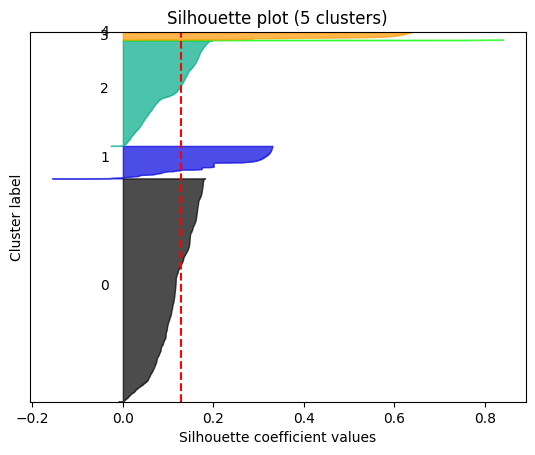

In [46]:
fig, ax = plt.subplots(1, 1)
ax.set_ylim([0, len(cluster_input) + (n_clusters + 1) * 10])

y_lower = 0
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax.set_title(f"Silhouette plot ({n_clusters} clusters)")
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])  # Clear the yaxis labels / ticks

# save to file

plt.

#### Move data back onto map

In [75]:
# generate some test data for mapping cluster labels back onto map
#num_false = (mask_main.shape[0]*mask_main.shape[1])-mask_main.mask.sum()
#cluster_labels = np.random.randint(1,21, size=num_false)

Create an output matrix

In [65]:
cluster_fill = 99

In [76]:
#cluster_map = np.ma.masked_array(np.zeros(mask_main.shape), mask_main.mask, fill_value=cluster_fill)
cluster_map = np.ma.masked_array(np.zeros(mask_main.shape), mask_main, fill_value=cluster_fill)

In [77]:
cluster_map[~cluster_map.mask] = kmeans.labels_

#### Save data (dataframe, geotiff)

In [81]:
cluster_desc = f'res_0-01_mask-MERIT-GLCLU2019_datasets-{len(file_paths)}_reruns-{n_reruns}'

In [82]:
cluster_path = base_path / 'clustering' / cluster_desc
cluster_path.mkdir(exist_ok=True, parents=True)

In [83]:
cluster_file = f'{cluster_desc}_clusters-{n_clusters}.tif'
cluster_full = str( cluster_path / cluster_file )

In [84]:
write_geotif_sameDomain(mask_file, cluster_full, cluster_map.filled(), no_data_value=cluster_fill)

### Functions

In [4]:
def get_geotiff_properties(file):

    with rasterio.open(file) as src:
        geoTransform = src.transform
        pixelSize = [geoTransform[0],geoTransform[4]]
        rasterSize = [src.width,src.height]
        boundingBox = src.bounds
    
    return pixelSize, rasterSize, boundingBox

In [5]:
def get_geotif_data_as_array(file, band=1):
    ds = gdal.Open(file) # open the file
    band = ds.GetRasterBand(band) # get the data band
    data = band.ReadAsArray() # convert to numpy array for further manipulation   
    return data

In [6]:
def get_geotif_noData(src_file, band=1):
    src_ds = gdal.Open(src_file)
    src_band = src_ds.GetRasterBand(band)
    no_data_value = src_band.GetNoDataValue()
    src_ds = None
    return no_data_value

In [7]:
def write_geotif_sameDomain(src_file, des_file, des_data, no_data_value=None, type=gdal.GDT_UInt16):
    
    # load the source file to get the appropriate attributes
    src_ds = gdal.Open(src_file)
    
    # get the geotransform
    des_transform = src_ds.GetGeoTransform()

    # Get the scale factor from the source metadata
    #scale_factor = src_ds.GetRasterBand(1).GetScale()
    #offset = src_ds.GetRasterBand(1).GetOffset()
    
    # get the data dimensions
    ncols = des_data.shape[1]
    nrows = des_data.shape[0]
    
    # make the file
    driver = gdal.GetDriverByName("GTiff")
    dst_ds = driver.Create(des_file,ncols,nrows,1, type, options = [ 'COMPRESS=DEFLATE' ])
    
    # Write the data
    #dst_ds.GetRasterBand(1).WriteArray( des_data )
    dst_band = dst_ds.GetRasterBand(1)
    dst_band.WriteArray(des_data)
    if no_data_value:
        dst_band.SetNoDataValue(no_data_value)
    
    # Set the scale factor and offset in the destination band, if they were defined in the source
    #if scale_factor: dst_ds.GetRasterBand(1).SetScale(scale_factor)
    #if offset: dst_ds.GetRasterBand(1).SetOffset(offset)
    
    # Set the geotransform
    dst_ds.SetGeoTransform(des_transform)

    # Set the projection
    wkt = src_ds.GetProjection()
    srs = osr.SpatialReference()
    srs.ImportFromWkt(wkt)
    dst_ds.SetProjection( srs.ExportToWkt() )
    
    # close files
    src_ds = None
    des_ds = None

    return